# Filtering Methods and Effects in Heart Sound Recordings
In this NoteBook we explore different filtering methods applied to Heart Sound Recordings (HSR) using Python. The HSR files used here are free available in (1). This database is characterize to be a set of single short recordings between 10 and 60 seconds.



The , perform filtering methods and analyse its effects over *the heart sound signal.*    

### Libraries needed

In [1]:

import os
import numpy as np
import wavio as wa
import sounddevice as sd
import ppfunctions_1 as ppf
import scipy.io.wavfile as wf

import matplotlib.pyplot as plt

## Signal Loading Process
We uses the **os** librarie to import the **.wav** files containing the heart sounds.

In [2]:
# -----------------------------------------------------------------------------
#                            Signal Loading Process
# -----------------------------------------------------------------------------
# Looking for heart sounds data absolute path 
l1=os.path.abspath('Data Base HS\\training\\training-a\\a0007.wav')
l1=l1.replace('\\','/')
l2=os.path.abspath('Data Base HS\\training\\training-a\\a0001.wav')
l2=l2.replace('\\','/')
# reading file
Fs1, data1 = wf.read(l1)
Fs2, data2 = wf.read(l2)
# Clear paths
del l1, l2

## Pre-Processing: Audio-Signal Basic Information (SBI)
This section is divided in two parts. The first part referred to the **Audio things** which involves **Signal Resampling** to ensure a sampling frequency of 2kHz and to convert the file into a **Mono sound**. The second part is make to get the **signal basic information (SBI)** which means the time duration of the recording and a vector time.

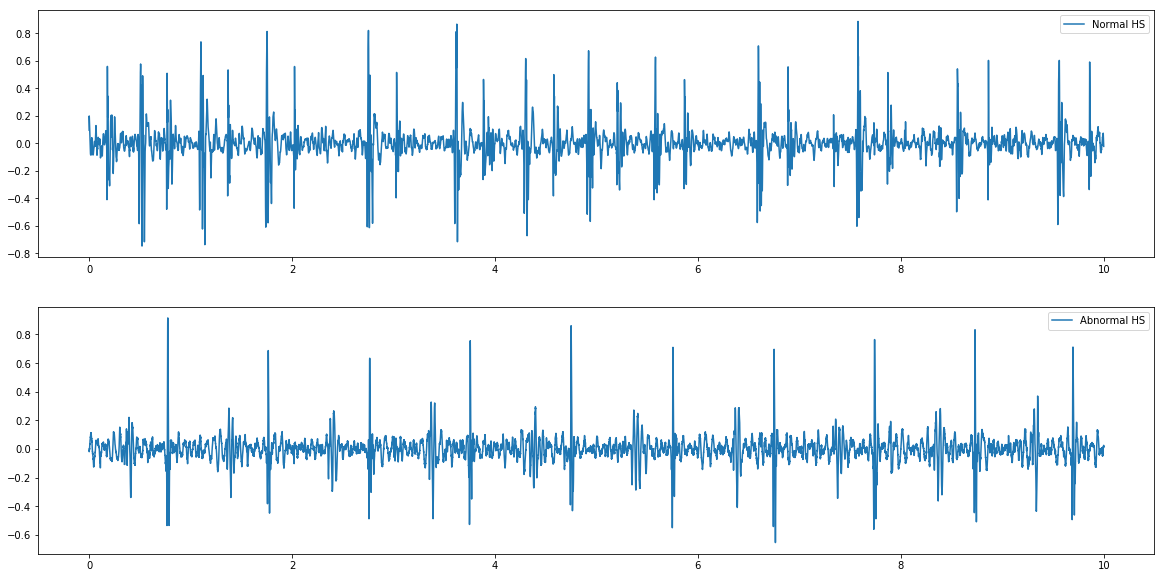

In [3]:
# Audio Pre-processing
data1, Fs1 = ppf.pre_pro_audio_PCG(data1, Fs1)
data2, Fs2 = ppf.pre_pro_audio_PCG(data2, Fs2)
# Signal basic information
dt1, vt1 = ppf.pre_pro_basicInfo_PCG(data1, Fs1)
dt2, vt2 = ppf.pre_pro_basicInfo_PCG(data2, Fs2)
# To show just ten seconds of the signal
idx1 = (np.abs(vt1-10)).argmin()
idx2 = (np.abs(vt2-10)).argmin()

plt.rcParams["figure.figsize"] = (20,10)

plt.subplot(2,1,1)
plt.plot(vt1[0:idx1], data1[0:idx1], label = "Normal HS")
plt.legend()
plt.subplot(2,1,2)
plt.plot(vt2[0:idx2], data2[0:idx2], label = "Abnormal HS")
plt.legend()
plt.show()

## Filtering Process
The information containg in the cardiac acoustic is found encode in both, Frequency and Time domain. For this reason, the ideal filter would be such as it has a good Step and Frequency Response. i.e. Butterworth.

Here we will explore the most common filters and its implementation through Python

### The Recursive Moving Average Filter

Its one of the most common FIR (Finite Impulse Response) filter, easy to understand, use and implement. Its good to reduce ramdon noise while retaining sharp step response. This means that it might performs well with signals which information are encode in the time domain. In contrast its little ability to separate one band of frequency to another makes it be some of the worst for frequency domain encoded signals.

The recursive Moving Average Filter its an algorithm to implement the typical moving average filter more faster. The algorithm is written as:
y[i] = y[i-1] + x[i+p] - x[i-q], where p = (M - 1)/2; M is the number of points in the moving average and q = p + 1


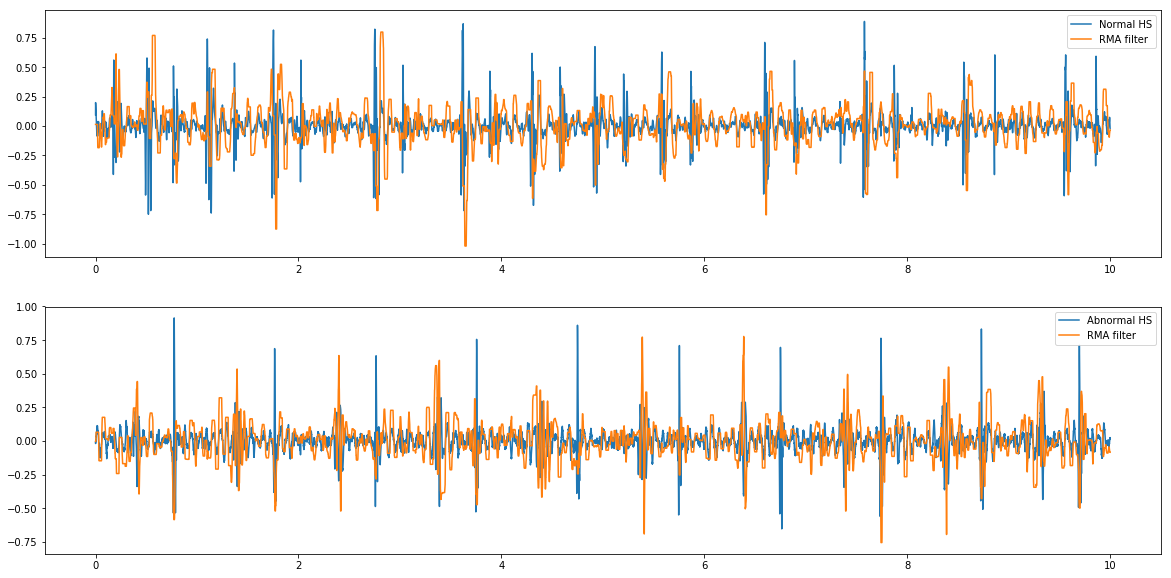

In [18]:
#d_RMAF_1 = ppf.recursive_moving_average_F(data1, Fs1, 1)
#d_RMAF_2 = ppf.recursive_moving_average_F(data2, Fs2, 1)
from scipy import signal as sg

d_RMAF_1 = ppf.vec_nor(sg.medfilt(data1, int(1+Fs1*0.05)))
d_RMAF_2 = ppf.vec_nor(sg.medfilt(data2, int(1+Fs2*0.05)))

plt.subplot(2,1,1)
plt.plot(vt1[0:idx1], data1[0:idx1], label = "Normal HS")
plt.plot(vt1[0:idx1], d_RMAF_1[0:idx1], label = "RMA filter")
plt.legend()
plt.subplot(2,1,2)
plt.plot(vt2[0:idx2], data2[0:idx2], label = "Abnormal HS")
plt.plot(vt2[0:idx2], d_RMAF_2[0:idx2], label = "RMA filter")
plt.legend()
plt.show()

As showed above, the RMA filter output signal is displaced to the right several points from the original signal

Lenght data 1 71332 Running Sum data 1 71332
Lenght data 2 71332 Running Sum data 2 71332


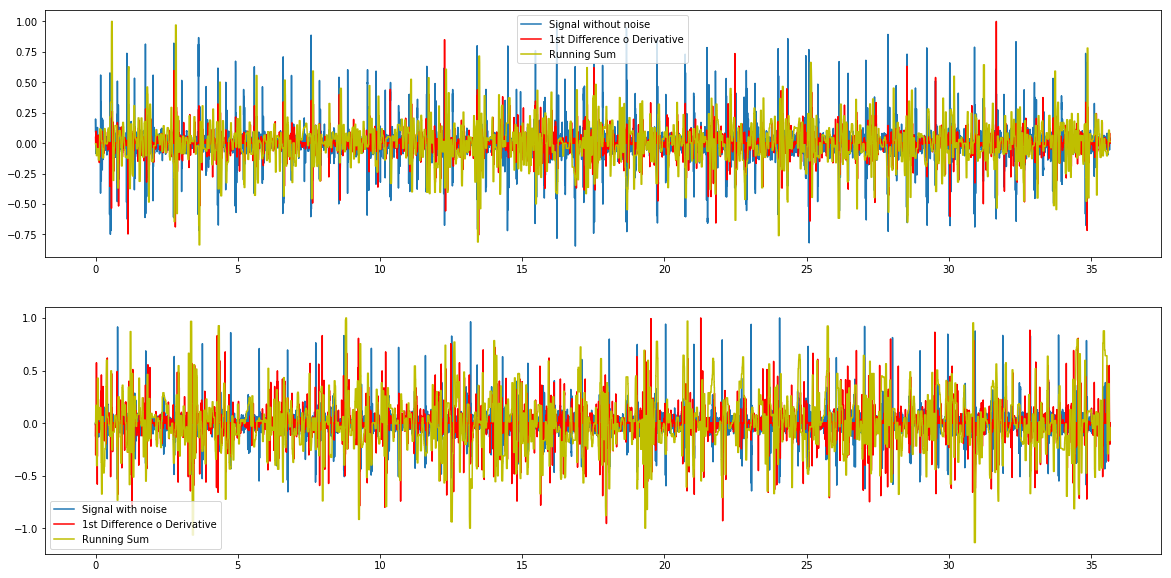

In [17]:
import mysignals as sigs
from scipy import signal

d1 = ppf.derivate(d_RMAF_1)
d2 = ppf.derivate(d_RMAF_2)

print('Lenght data 1', len(data1), 'Running Sum data 1', len(d1))
print('Lenght data 2', len(data2), 'Running Sum data 2', len(d2))

plt.subplot(2,1,1)
plt.plot(vt1, data1, label = "Signal without noise")
plt.plot(np.linspace(0,dt1,np.size(d1)), ppf.vec_nor(d1), 'r', label = "1st Difference o Derivative")
plt.plot(vt1, ppf.vec_nor(d_RMAF_1), 'y', label = "Running Sum")
plt.legend()
plt.subplot(2,1,2)
plt.plot(vt2, data2, label = "Signal with noise")
plt.plot(np.linspace(0,dt2,np.size(d2)), ppf.vec_nor(d2), 'r', label = "1st Difference o Derivative")
plt.plot(vt2, ppf.vec_nor(d_RMAF_2), 'y', label = "Running Sum")
plt.legend()
plt.show()


